In [70]:
# Cell 1: General code cell.




# Outlines:
- [0-Introduction](#0)
- [1- Import Data and Packages](#1)
- [2- Feature Extraction](#2)
- [3- EDA](#3)
    - [3.1 - Scatter matrix](#3.1)
    - [3.2 - Univariate Analysis](#3.2)
    - [3.3 - Plotting Colinearity](#3.3)
    - [3.4 - Numerical Columns over the date columns](#3.4)
- [4- Preprocessing and Transformers](#4)
    - [4.1- Pipeline](#4.1)
- [5- Feature Importance](#5)
- [6- Modeling](#6)
    - [6.1 - Plot Model Scores](#6.1)
    - [6.2 - Final Model](#6.2)
    - [6.3 - Cross-Validation Scores](#6.3)
- [7- Plot Real/Predicted/Actual Power](#7)

<a name="0"></a>
# Introduction
#### In the modern era, wind turbines have emerged as pivotal components of the global energy landscape. Operating on a straightforward principle, these turbines harness the kinetic energy of the wind to rotate blades connected to a rotor, ultimately driving a generator that produces electricity. This clean and renewable energy source has experienced remarkable growth, with wind power capacity rapidly expanding across continents.
The environmental advantages of wind turbines are profound. They generate no greenhouse gas emissions or air pollutants during operation, making them indispensable in efforts to combat climate change and diminish dependence on fossil fuels. Additionally, wind energy is abundant and everlasting, offering a reliable power source for future generations.

### About Dataset
In Wind Turbines, SCADA Systems measure and save data such as wind speed, wind direction, generated power, etc. at 10-minute intervals. This file contains data from a wind turbine's SCADA system that is operational and generating power in Turkey.

### Content
#### The data in the file includes:

* Date/Time (for 10-minute intervals)
* LV ActivePower (kW): The power generated by the turbine for that moment
* Wind Speed (m/s): The wind speed at the hub height of the turbine (the wind speed that the turbine uses for electricity generation)
* Theoretical Power Curve (KWh): The theoretical power values that the turbine generates with that wind speed, which is provided by the turbine manufacturer
* Wind Direction (°): The wind direction at the hub height of the turbine (wind turbines automatically turn to this direction)

In [71]:
# Cell 5: Set up environment and import libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
# Attempting to use TensorFlow
warnings.simplefilter("ignore")

In [72]:
# Cell 6: Load dataset(s) from disk into memory.

df = pd.read_csv('data/T1.csv')
df

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


In [73]:
# Cell 7: General code cell.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [74]:
# Cell 8: General code cell.

df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [75]:
#There is negative values in the actual power column
count_negative_values = (df['LV ActivePower (kW)'] < 0).sum()
count_negative_values

np.int64(57)

In [76]:
# Cell 10: SCADA-specific logic and fault detection steps.

df.loc[df['LV ActivePower (kW)'] < 0, 'LV ActivePower (kW)'] = 0

<a name="2"></a>
# 2 - Feature Extraction
#### Extract new features from the Date/Time Column

In [77]:
#Save a copy for the pipeline and split it
df_copy=df.copy()

In [78]:
# Cell 13: General code cell.

df['Date/Time']=pd.to_datetime(df['Date/Time'],format='%d %m %Y %H:%M')

In [79]:
# Cell 14: General code cell.

df['Week']=df['Date/Time'].dt.day // 7 + 1

df['Week'].value_counts()

Week
3    11948
4    11809
2    11645
1     9924
5     5204
Name: count, dtype: int64

In [80]:
# Cell 15: General code cell.

df['Month']=df['Date/Time'].dt.month

In [81]:
# Cell 16: General code cell.

seasons_dict = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}
df['Seasons'] = df['Month'].map(seasons_dict)

In [82]:
# Cell 17: General code cell.

df['Day']=df['Date/Time'].dt.day

In [83]:
# Cell 18: General code cell.

df['Hour']=df['Date/Time'].dt.hour+1

In [84]:
# Cell 19: General code cell.

df.drop(columns=['Date/Time'],inplace=True)

In [85]:
# Cell 20: Clean and preprocess data (impute, encode, scale, split).

df.isna().sum()

LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
Week                             0
Month                            0
Seasons                          0
Day                              0
Hour                             0
dtype: int64

Split The Data¶

In [86]:
# Cell 22: Clean and preprocess data (impute, encode, scale, split).

from sklearn.model_selection import train_test_split
df_train,df_test=train_test_split(df,test_size=0.2,random_state=42)
df_copy_train,df_copy_test=train_test_split(df_copy,test_size=0.2,random_state=42)

<a name="3"></a>
# 3 - EDA

In [87]:
#Intialize Numerical and Date Columns
date_col=['Week','Month','Seasons','Hour','Day']
num_col=['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)',]

array([[<Axes: title={'center': 'LV ActivePower (kW)'}>,
        <Axes: title={'center': 'Wind Speed (m/s)'}>],
       [<Axes: title={'center': 'Theoretical_Power_Curve (KWh)'}>,
        <Axes: title={'center': 'Wind Direction (°)'}>]], dtype=object)

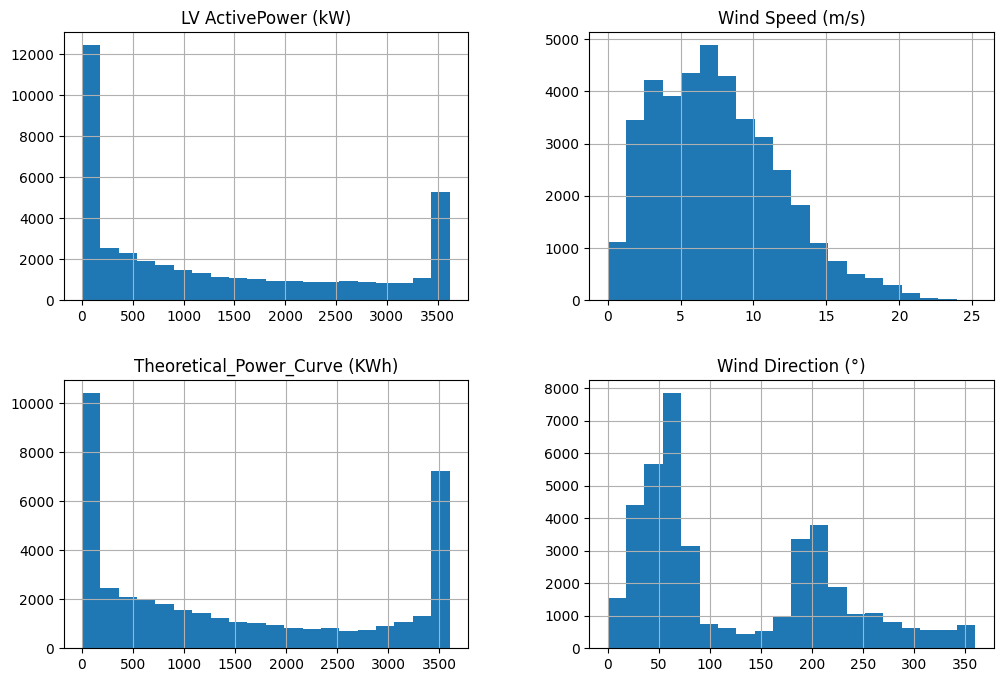

In [88]:
# Cell 25: Plot charts/figures for data or results.

df_train[num_col].hist(bins=20,figsize=(12,8))

<a name="3.1"></a>
## 3.1 - Scatter matrix

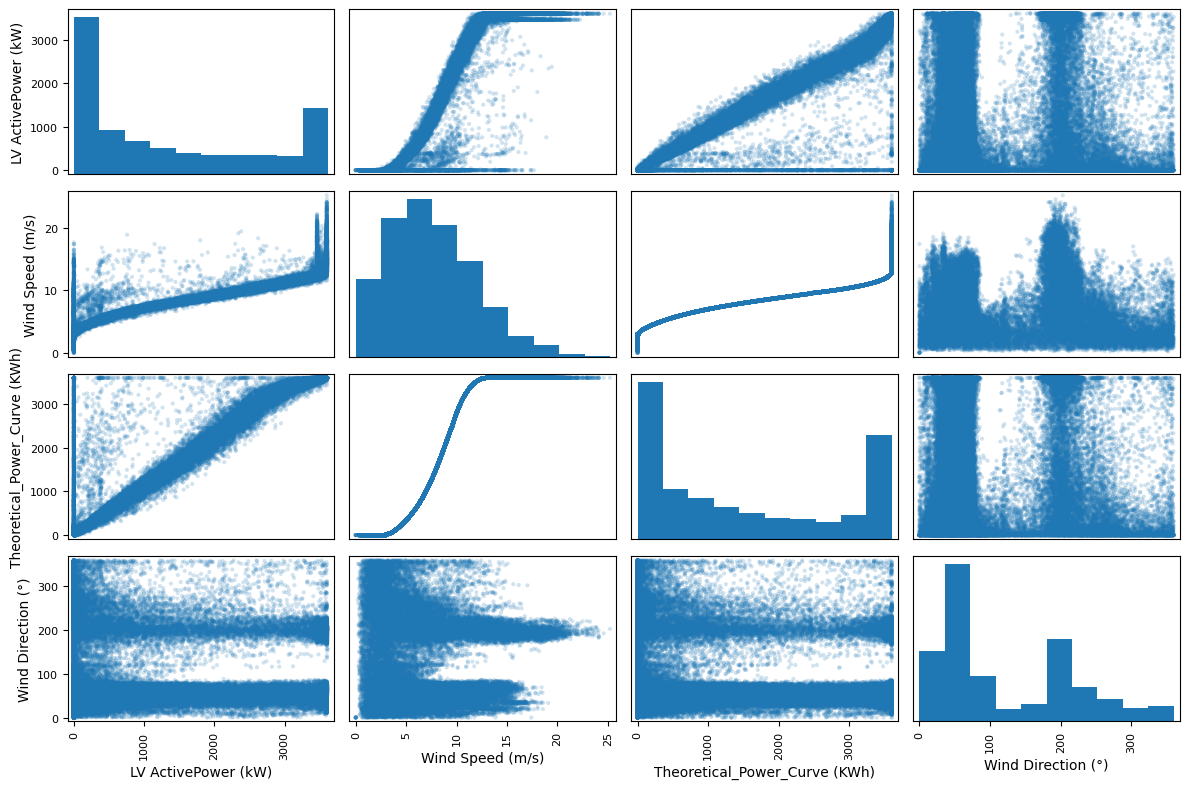

In [89]:
# Cell 27: Plot charts/figures for data or results.

pd.plotting.scatter_matrix(df[num_col], alpha=0.2, figsize=(12, 8))
plt.tight_layout()
plt.show()

* Comments:
    * from the scatter plot between wind speed and Theoritical Power Curve, we see that Wind Turbines Systems can't generate any power if the wind speed is less than 4 m/s
    * when the wind speed is larger than 4 m/s to 11 m/s, the relation between them are linear meaning that increasing the wind speed, allows turbines to generate more power
    * after the wind speed passes 11 m/s, the power generated is saturated on 3600 KWh

<a name="3.2"></a>
## 3.2 - Univariate Analysis

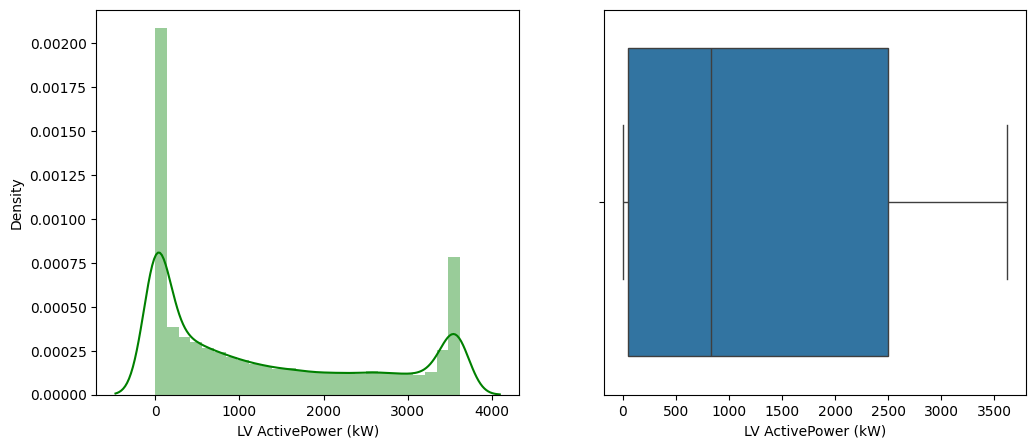

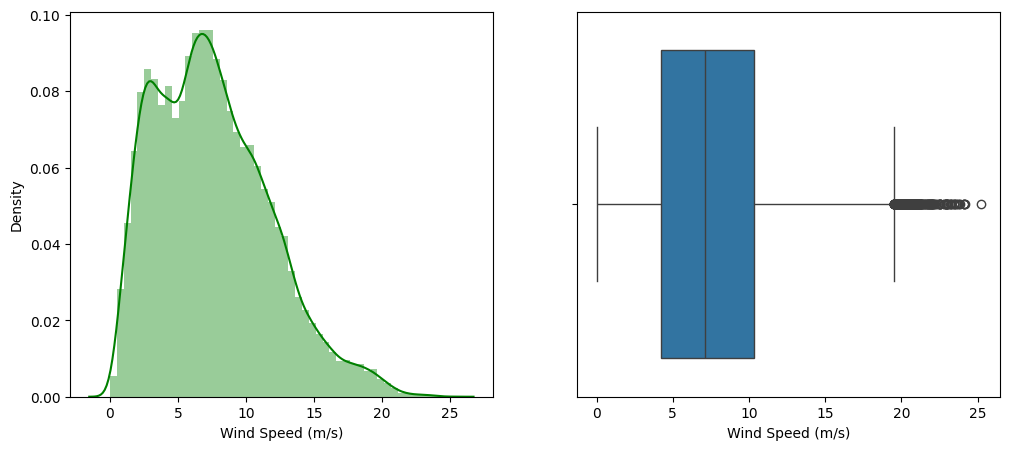

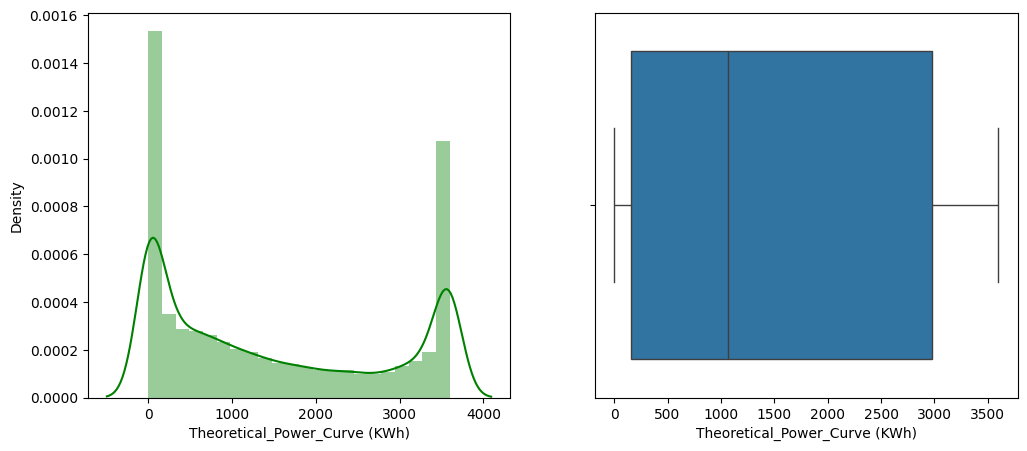

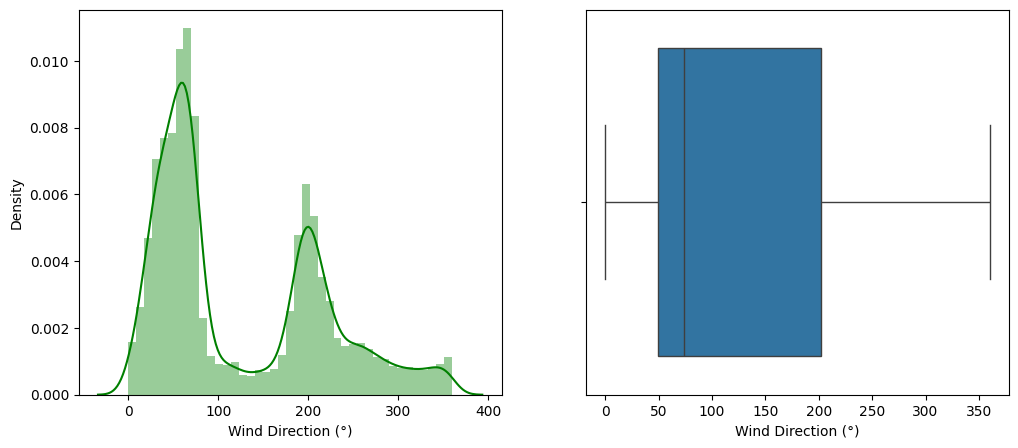

In [90]:
# Cell 30: Plot charts/figures for data or results.

for col in num_col:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.distplot(df_train[col], ax=ax[0] ,color='green')  
    sns.boxplot(x=df_train[col], ax=ax[1])
    plt.show()

<a name="3.3"></a>
## 3.3 - Plotting Colinearity

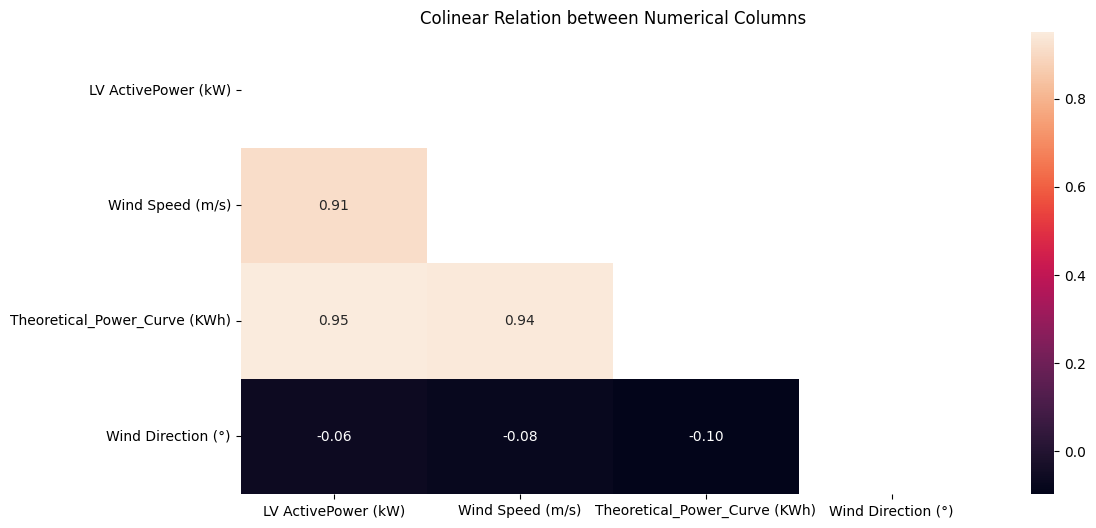

In [91]:
# Cell 32: Plot charts/figures for data or results.

corr = df_train[num_col].corr(numeric_only=True)
mask = np.triu(corr)
mask=mask
plt.figure(figsize=(12, 6))
plt.title('Colinear Relation between Numerical Columns')
sns.heatmap(corr, annot=True,mask=mask, fmt='.2f')
sns.color_palette("magma", as_cmap=True)
plt.show()

<a name="3.4"></a>
## 3.4 - Numerical Columns over the date columns
#### Numerical Columns over the Weeks

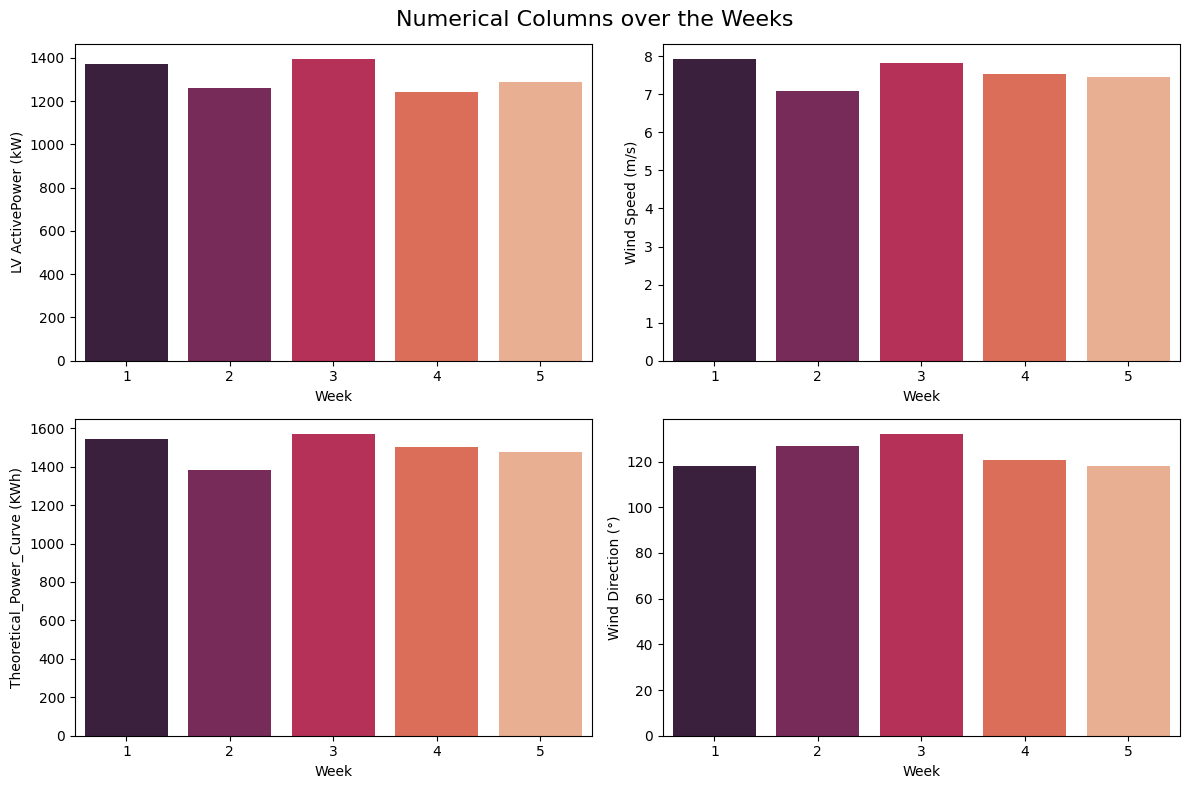

In [92]:
# Cell 34: Plot charts/figures for data or results.

fig,axes=plt.subplots(nrows=len(num_col)//2 ,ncols=2,figsize=(12,8))
for idx,col in enumerate(df_train[num_col]):
    row_idx=idx//2
    col_idx=idx%2
    sns.barplot(x=df_train['Week'],y=df_train[col],data=df_train,ax=axes[row_idx,col_idx],errorbar=None,palette='rocket')
fig.suptitle('Numerical Columns over the Weeks', fontsize=16)
plt.tight_layout()
plt.show() 

### Numerical Columns for each Month

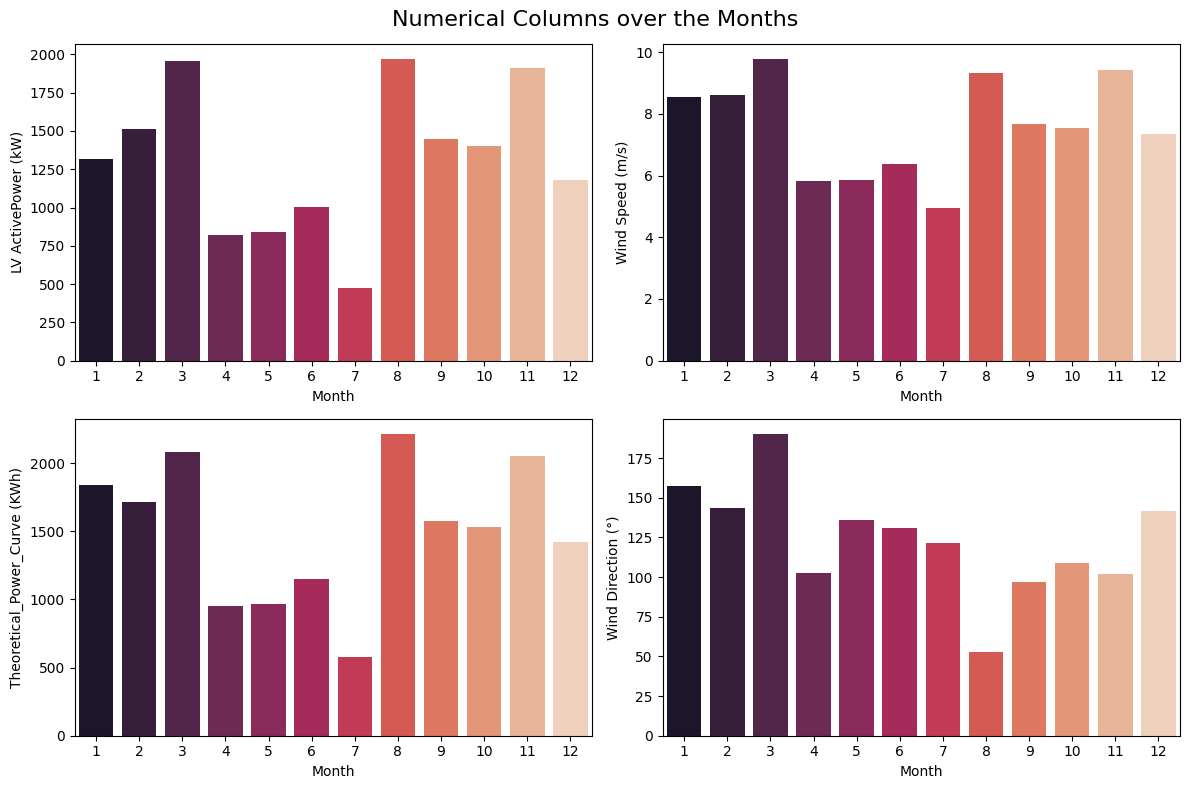

In [93]:
# Cell 36: Plot charts/figures for data or results.

fig,axes=plt.subplots(nrows=len(num_col)//2 ,ncols=2,figsize=(12,8))
for idx,col in enumerate(df_train[num_col]):
    row_idx=idx//2
    col_idx=idx%2
    sns.barplot(x=df_train['Month'],y=df_train[col],data=df_train,ax=axes[row_idx,col_idx],errorbar=None,palette='rocket')
fig.suptitle('Numerical Columns over the Months', fontsize=16)
plt.tight_layout()
plt.show() 

### Numerical Columns over the Seasons

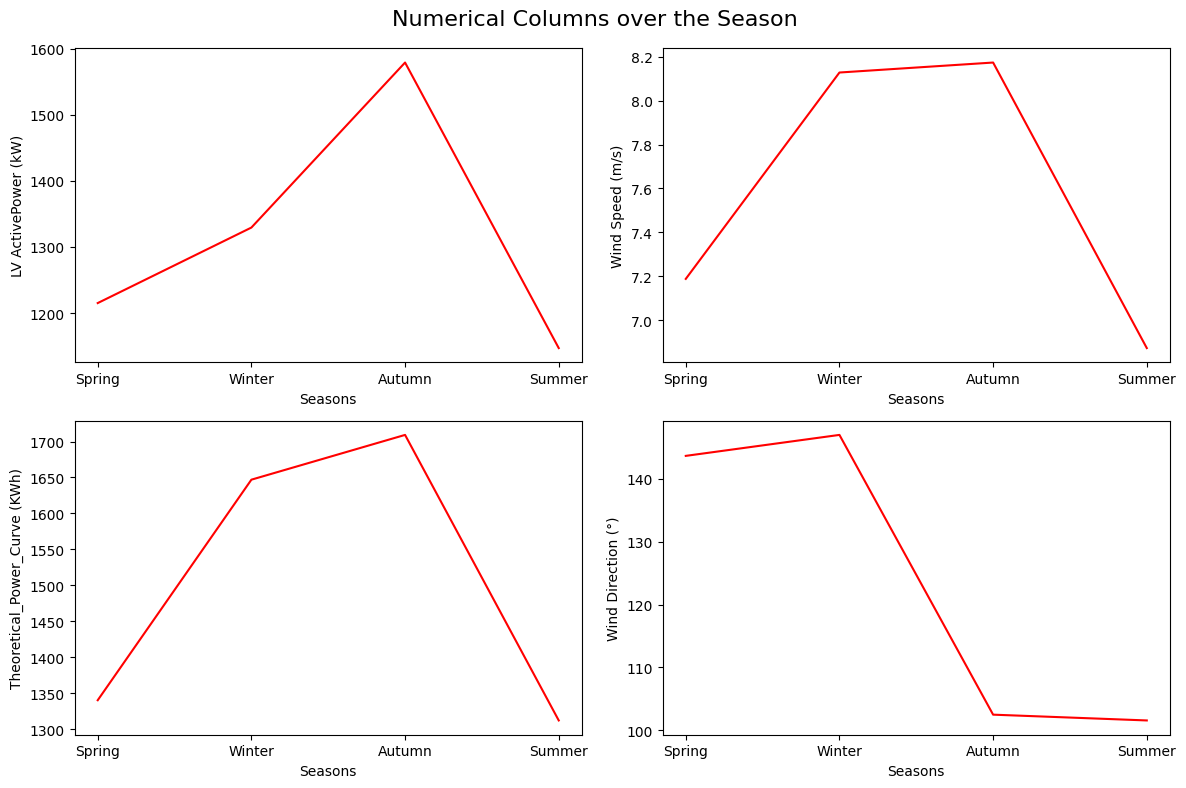

In [94]:
# Cell 38: Plot charts/figures for data or results.

fig,axes=plt.subplots(nrows=len(num_col)//2 ,ncols=2,figsize=(12,8))
for idx,col in enumerate(df_train[num_col]):
    row_idx=idx//2
    col_idx=idx%2
    sns.lineplot(x='Seasons',y=df_train[col],data=df_train,ax=axes[row_idx,col_idx],ci=None,color='red')
fig.suptitle('Numerical Columns over the Season', fontsize=16)
plt.tight_layout()
plt.show() 

In [95]:
# # --- QUYẾT ĐỊNH XỬ LÝ DỮ LIỆU NGOÀI PIPELINE ---
# # Dựa trên phân tích EDA, chúng ta xác định các điểm dữ liệu có thể là trạng thái "bảo trì"
# # (Power = 0 dù có gió mạnh) và loại bỏ chúng ra khỏi TẬP HUẤN LUYỆN.

# print(f"Số lượng bản ghi trong tập huấn luyện TRƯỚC khi lọc: {len(df_copy_train)}")

# # Tạo một mask để xác định các điểm "bảo trì" trong tập huấn luyện
# # Chú ý: Chúng ta chỉ lọc trên df_copy_train, không đụng đến df_copy_test
# maintenance_mask = (df_copy_train['LV ActivePower (kW)'] == 0) & (df_copy_train['Wind Speed (m/s)'] > 4)

# # Lọc bỏ các điểm này. Dấu ~ có nghĩa là "phủ định" (NOT)
# df_copy_train = df_copy_train[~maintenance_mask]

# print(f"Số lượng bản ghi trong tập huấn luyện SAU khi lọc: {len(df_copy_train)}")

# # Bây giờ, khi Cell 42 chạy, X_train và y_train sẽ được tạo ra từ bộ df_copy_train đã được lọc sạch.
# # Tập test (df_copy_test) được giữ nguyên để mô phỏng dữ liệu thực tế, có thể chứa cả trạng thái bảo trì.

<a name="4"></a>
# 4 - Preprocessing

In [96]:
# Cell 40: Clean and preprocess data (impute, encode, scale, split).

from sklearn.preprocessing import LabelEncoder, Normalizer, StandardScaler, MinMaxScaler, RobustScaler,OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.ensemble import RandomForestRegressor

### Split the Target and Label Columns

In [97]:
# Cell 42: SCADA-specific logic and fault detection steps.

X_train,y_train,X_test,y_test=df_copy_train.drop(columns='LV ActivePower (kW)'),df_copy_train['LV ActivePower (kW)'],df_copy_test.drop(columns='LV ActivePower (kW)'),df_copy_test['LV ActivePower (kW)']

In [98]:
# Cell 43: General code cell.

print("The Shape of X_train is :",X_train.shape)
print("The Shape of y_train is :",y_train.shape)
print("The Shape of X_test is :",X_test.shape)
print("The Shape of y_test is :",y_test.shape)

The Shape of X_train is : (40424, 4)
The Shape of y_train is : (40424,)
The Shape of X_test is : (10106, 4)
The Shape of y_test is : (10106,)


<a name="4.1"></a>
# 4.1 - Custom Transformers & Pipeline

In [99]:
# Cell 45: Clean and preprocess data (impute, encode, scale, split).

class StandardScaleTransform(BaseEstimator, TransformerMixin):
    """
    A transformer class to apply standard scaling to specified columns in a Pandas DataFrame.

    Parameters
    ----------
    cols : list of str
        The names of the columns to apply standard scaling to.
    """
    def __init__(self, cols):
        self.cols = cols
        self.scaler_ = None

    def fit(self, X, y=None):
        self.scaler_ = StandardScaler().fit(X.loc[:, self.cols])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy.loc[:, self.cols] = self.scaler_.transform(X_copy.loc[:, self.cols])
        return X_copy

    def fit_transform(self, X, y=None):
        self.scaler_ = StandardScaler().fit(X.loc[:, self.cols])
        return self.transform(X)

In [100]:
# Cell 46: Clean and preprocess data (impute, encode, scale, split).

class DataFrameImputer(TransformerMixin, BaseEstimator):
    """
    A class to impute missing values in a Pandas DataFrame using a combination of median, knn, and most frequent
    imputers on specified columns.

    Parameters:
    -----------
    median_cols : list of str, optional (default=None)
        Columns to impute missing values using the median imputer.
    knn_cols : list of str, optional (default=None)
        Columns to impute missing values using the KNN imputer.

    Returns:
    --------
    X_imputed : pandas.DataFrame
        A DataFrame with imputed missing values.
    """
    def __init__(self, median_cols=None, knn_cols=None):
        self.median_cols = median_cols
        self.knn_cols = knn_cols
    
    def fit(self, X, y=None):
        self.median_imputer = SimpleImputer(strategy='median')
        self.knn_imputer = KNNImputer()

        if self.median_cols is not None:
            self.median_imputer.fit(X[self.median_cols])
        if self.knn_cols is not None:
            self.knn_imputer.fit(X[self.knn_cols])
        return self
    
    def transform(self, X):
        X_imputed = X.copy()
        if self.median_cols is not None:
            X_median = pd.DataFrame(self.median_imputer.transform(X[self.median_cols]), 
                                    columns=self.median_cols, index=X.index)
            X_imputed = pd.concat([X_imputed.drop(self.median_cols, axis=1), X_median], axis=1)
        if self.knn_cols is not None:
            X_knn = pd.DataFrame(self.knn_imputer.transform(X[self.knn_cols]), 
                                 columns=self.knn_cols, index=X.index)
            X_imputed = pd.concat([X_imputed.drop(self.knn_cols, axis=1), X_knn], axis=1)
        return X_imputed
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [101]:
# Cell 47: Train machine learning model(s).

class DateExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, date_cols):
        self.date_cols = date_cols
         

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        extracted_features = []
        for col in self.date_cols:
            dates = pd.to_datetime(X[col], format='%d %m %Y %H:%M')
            for date in dates:
                month_val = date.month
                week_val = date.day // 7 + 1
                day_val = date.day
                hour_val = date.hour + 1
                # Determining season based on month
                if month_val in [3, 4, 5]:
                    season_val = 'Spring'
                elif month_val in [6, 7, 8]:
                    season_val = 'Summer'
                elif month_val in [9, 10, 11]:
                    season_val = 'Autumn'
                else:
                    season_val = 'Winter'
                extracted_features.append([month_val, week_val, day_val, season_val, hour_val])

        # Convert the extracted features list to a DataFrame
        X_date = pd.DataFrame(extracted_features, columns=['Month', 'Week', 'Day', 'Season', 'Hour'])
        X_new=pd.concat([X.reset_index(drop=True),X_date],axis=1)
        return X_new
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [102]:
# Cell 48: Train machine learning model(s).

# class OutlierThresholdTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, column, q1=0.25, q3=0.75):
#         self.column = column
#         self.q1 = q1
#         self.q3 = q3
#     def outlier_threshhold(self, dataframe, column):
#         Q1 = dataframe[column].quantile(self.q1)
#         Q3 = dataframe[column].quantile(self.q3)
#         iqr = Q3 - Q1
#         up_limit = Q3 + 1.5 * iqr
#         low_limit = Q1 - 1.5 * iqr
#         return low_limit, up_limit

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X_copy = X.copy()
#         for col in self.column:
#             low_limit, up_limit = self.outlier_threshhold(X_copy, col)
#             X_copy.loc[(X_copy[col] < low_limit), col] = low_limit
#             X_copy.loc[(X_copy[col] > up_limit), col] = up_limit
#         return X_copy

#     def fit_transform(self, X, y=None):
#         return self.transform(X)
class OutlierThresholdTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column, q1=0.25, q3=0.75):
        self.column = column
        self.q1 = q1
        self.q3 = q3
        self.thresholds_ = {}  # will store per-column thresholds

    def fit(self, X, y=None):
        self.thresholds_ = {}
        for col in self.column:
            Q1 = X[col].quantile(self.q1)
            Q3 = X[col].quantile(self.q3)
            iqr = Q3 - Q1
            up_limit = Q3 + 1.5 * iqr
            low_limit = Q1 - 1.5 * iqr
            self.thresholds_[col] = (low_limit, up_limit)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.column:
            low_limit, up_limit = self.thresholds_[col]
            X_copy.loc[X_copy[col] < low_limit, col] = low_limit
            X_copy.loc[X_copy[col] > up_limit, col] = up_limit
        return X_copy


In [103]:
# Cell 49: Train machine learning model(s).

class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    """
    A transformer that drops specified columns from a DataFrame.

    Parameters
    ----------
    columns : list
        A list of column names to be dropped.
    return
    ------
        dataframe with dropped columns
    """
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.columns is None:
            return X
        else:
            return X.drop(self.columns,axis=1)

In [104]:
# Cell 50: Clean and preprocess data (impute, encode, scale, split).

class CustomOneHotEncoder(BaseEstimator, TransformerMixin):

    """
    A transformer class to apply one-hot encoding to specified columns in a Pandas DataFrame.

    Parameters
    ----------
    columns : list
        A list of column names to encode.

    Returns
    -------
    pandas.DataFrame
        A new DataFrame with the specified columns one-hot encoded.
    """
    def __init__(self, columns=None):
        self.columns = columns
        self.unique_values = {} 
        self.feature_names_ = None

    def fit(self, X, y=None):
        if self.columns is None:
            self.columns = X.columns.tolist() 
        self.unique_values = {col: X[col].unique() for col in self.columns}
        self.feature_names_ = self._get_feature_names()
        return self
    def _get_feature_names(self):
        feature_names = []
        for col in self.columns:
            for value in self.unique_values[col]:
                feature_names.append(f"{col}_{value}")
        return feature_names
    def transform(self, X):
        X_transformed = pd.DataFrame(index=X[self.columns].index)
                                     
        for col in self.columns:
            for value in self.unique_values[col]:
                X_transformed[f"{col}_{value}"] = (X[col] == value).astype(int)
        
        X = pd.concat([X, X_transformed], axis=1)
        return X.drop(columns=['Season'])
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [105]:
# Cell 51: Clean and preprocess data (impute, encode, scale, split).

class LabelEncodeColumns(BaseEstimator, TransformerMixin):
    """
    A transformer class to encode categorical columns using LabelEncoder.

    Parameters
    ----------
    columns : list of str
        The names of the columns to be encoded.

    return
    ------
        encoded feature
    """
    def __init__(self, columns):
        self.columns = columns
        self.encoders_ = {}

    def fit(self, X, y=None):
        for col in self.columns:
            encoder = LabelEncoder()
            encoder.fit(X[col])
            self.encoders_[col] = encoder
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col, encoder in self.encoders_.items():
            X_copy[col] = encoder.transform(X_copy[col])
        return X_copy

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [106]:
# Cell 52: Clean and preprocess data (impute, encode, scale, split).

class FullPipeline1:
    def __init__(self) :
        self.date_cols=['Date/Time']
        self.numerical_cols=['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)','Week','Month','Hour','Day']
        self.MLE_cols=['Season']
        self.full_pipeline=Pipeline([
            ('extract_date',DateExtractor(date_cols=self.date_cols)),
            ('label_encode', CustomOneHotEncoder(columns=self.MLE_cols)),
            #('label_encode', LabelEncodeColumns(columns=self.MLE_cols)),
            ('impute_num',DataFrameImputer(knn_cols=self.numerical_cols)),
            ('remove_outlier',OutlierThresholdTransformer(column=self.numerical_cols)),
            ('scale', StandardScaleTransform(cols=self.numerical_cols)),
            ('drop', DropColumnsTransformer(columns=self.date_cols)),
           
        ])
    def fit_transform(self, X_train):
        X_train = self.full_pipeline.fit_transform(X_train)
        return X_train
    def transform(self, X_test):
        X_test = self.full_pipeline.transform(X_test)
        return X_test
f1=FullPipeline1()
X_1_train_f1=f1.fit_transform(X_train)
X_1_test_f1=f1.transform(X_test)

In [107]:
# Cell 53: General code cell.

X_1_train_f1.head()

,Season_Spring,Season_Winter,Season_Autumn,Season_Summer,Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Week,Month,Hour,Day
0,1,0,0,0,-1.131041,-1.091661,0.600542,-0.641252,-0.738439,-0.800917,-0.533974
1,0,1,0,0,-0.616778,-0.852852,-0.007299,-1.424629,1.605546,-0.800917,-1.569184
2,0,0,1,0,1.231326,1.531968,0.937698,1.708881,1.019550,0.928508,1.651468
3,0,0,0,1,-0.110304,-0.318188,-0.744266,-1.424629,-0.152443,-0.368561,-1.684207
4,1,0,0,0,-0.303991,-0.564102,-0.869168,1.708881,-1.031437,0.352033,1.421421


<a name="5"></a>
# 5 - Feature Importance

In [108]:
#Create and train a Random Forest regressor
model=RandomForestRegressor(random_state=42)
model.fit(X_1_train_f1,y_train)
feature_importance=model.feature_importances_
#Create a DataFrame to associate feature names with their importances
feature_importance_df=pd.DataFrame({'Feature':X_1_train_f1.columns,'Importance':feature_importance})
#Sort feature by importance
feature_importance_df=feature_importance_df.sort_values(by='Importance',ascending=False)

In [109]:
# Cell 56: Clean and preprocess data (impute, encode, scale, split).

feature_importance_df

,Feature,Importance
4,Wind Speed (m/s),0.467188
5,Theoretical_Power_Curve (KWh),0.453834
6,Wind Direction (°),0.025089
10,Day,0.023817
8,Month,0.013416
9,Hour,0.008390
1,Season_Winter,0.003750
7,Week,0.003392
3,Season_Summer,0.000563
2,Season_Autumn,0.000319


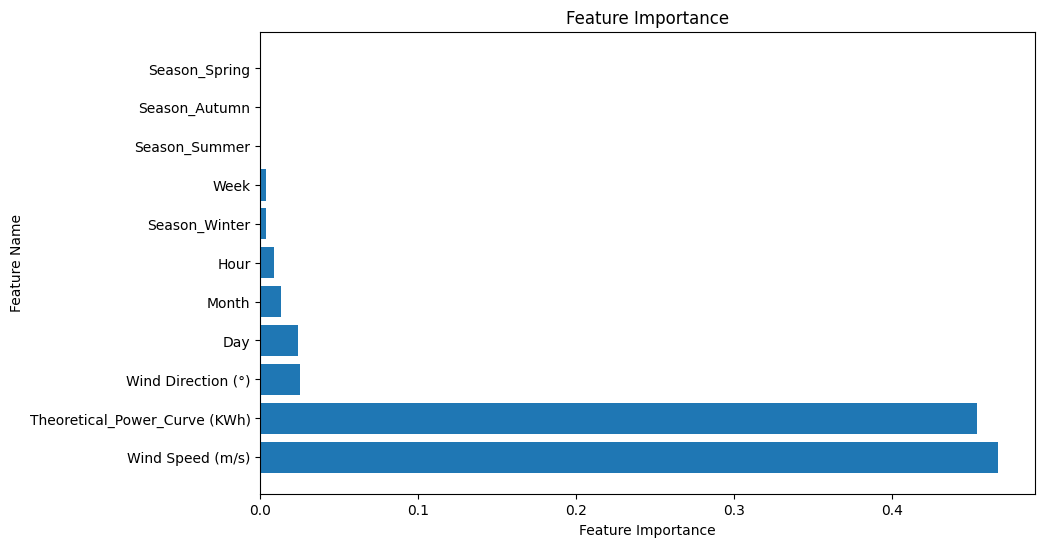

In [110]:
# Cell 57: Plot charts/figures for data or results.

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance')
plt.show()

<a name="6"></a>
# 6 - Modeling

In [111]:
# Cell 59: Set up environment and import libraries.

from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor,XGBRFRegressor
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor

In [112]:
# Cell 60: Train machine learning model(s).

model_name = []
r2score = []
rmse = []
mae=[]
models = [
    GradientBoostingRegressor(random_state=42),
    SVR(),
    RandomForestRegressor(random_state=42),
    LinearRegression(),
    ExtraTreesRegressor(random_state=42),
    AdaBoostRegressor(random_state=42),
    DecisionTreeRegressor(random_state=42),
    XGBRegressor(random_state=42),
    XGBRFRegressor(random_state=42),
    CatBoostRegressor(random_state=42, verbose=False)
]

for model in models:
    model.fit(X_1_train_f1, y_train)
    y_pred = model.predict(X_1_test_f1)

    model_name.append(model.__class__.__name__)
    r2score.append(r2_score(y_test, y_pred) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae.append(str(mean_absolute_error(y_test, y_pred)))

In [113]:
# Cell 61: Clean and preprocess data (impute, encode, scale, split).

# The DataFrame now includes the 'MAE' column
models_df = pd.DataFrame({"Model-Name":model_name, "R2_score": r2score, 'RMSE':rmse, 'MAE': mae})
models_df = models_df.astype({"R2_score": float, "RMSE": float, "MAE": float})
models_df.sort_values("R2_score", ascending = False)

,Model-Name,R2_score,RMSE,MAE
9,CatBoostRegressor,98.254082,172.600073,77.369416
7,XGBRegressor,98.145471,177.887655,76.124406
4,ExtraTreesRegressor,97.739480,196.396263,70.711838
2,RandomForestRegressor,97.398531,210.687276,77.401477
6,DecisionTreeRegressor,95.528001,276.235730,93.217519
0,GradientBoostingRegressor,94.777728,298.509905,132.187312
8,XGBRFRegressor,94.513065,305.980617,127.848887
3,LinearRegression,90.607736,400.326309,205.612457
1,SVR,88.482679,443.307140,256.519930
5,AdaBoostRegressor,86.857825,473.546488,293.146682


<a name="6.1"></a>
## 6.1 - Plot Model Scores

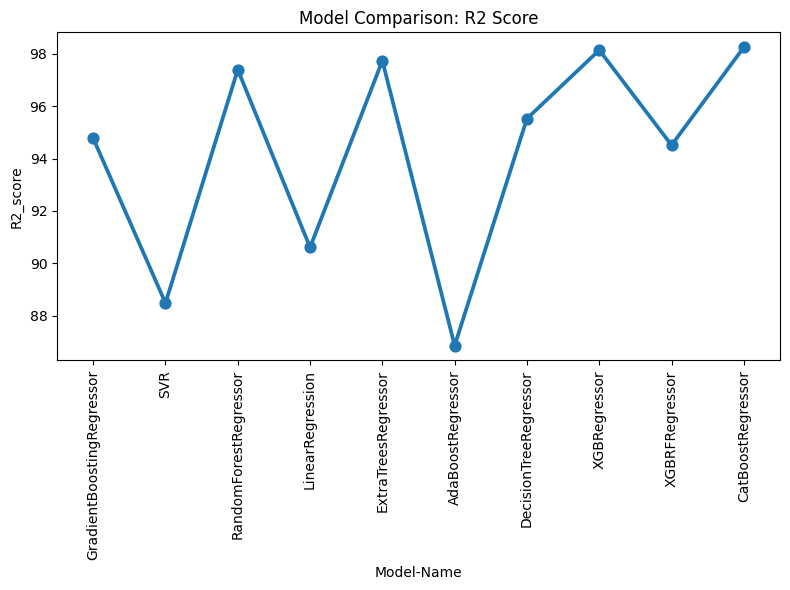

In [114]:
# Cell 63: Plot charts/figures for data or results.

plt.figure(figsize=(8,6))
sns.pointplot(x='Model-Name',y='R2_score',data=models_df)
plt.xticks(rotation=90)
plt.title('Model Comparison: R2 Score')
plt.tight_layout()
plt.show()

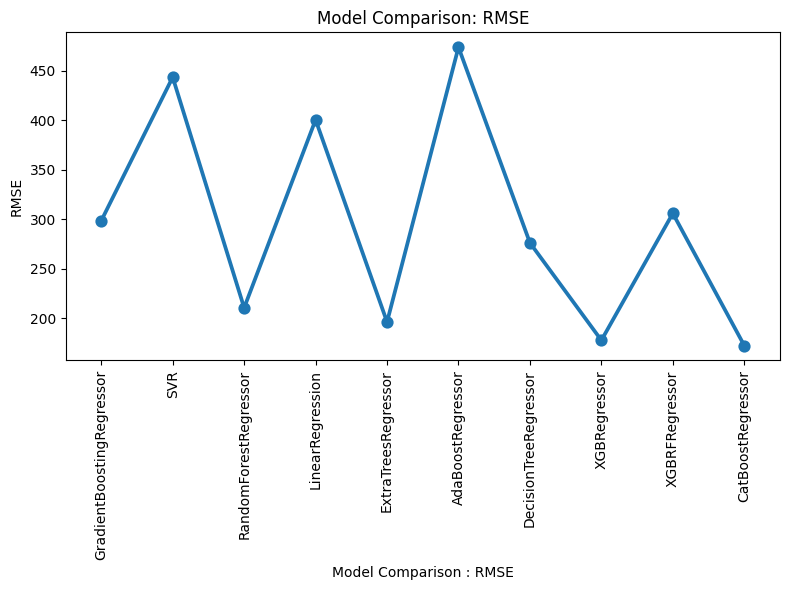

In [115]:
# Cell 64: Plot charts/figures for data or results.

plt.figure(figsize=(8,6))
plt.xlabel('Model Comparison : RMSE')
sns.pointplot(x='Model-Name',y='RMSE',data=models_df)
plt.xticks(rotation=90)
plt.title('Model Comparison: RMSE')
plt.tight_layout()
plt.show()

<a name="6.2"></a>
## 6.2 - Final Model

In [116]:
# Cell 66: Train machine learning model(s).

fm=CatBoostRegressor(random_state=42)

#### Fine Tune your model

In [117]:
#Prepare a set of hyperparameters to search over
param_grid = {
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'iterations': [100, 200, 300, 400, 500],  # Equivalent to n_estimators
    'depth': [3, 5, 7, 9],  # Equivalent to max_depth
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bylevel': np.linspace(0.5, 1.0, 6),  # Equivalent to colsample_bytree
    'l2_leaf_reg': np.linspace(0.01, 1.0, 10),  # Equivalent to reg_lambda
    'min_child_samples': [1, 5, 10, 15],  # Equivalent to min_child_weight 
}

In [118]:
#Create the GridSearchCV object and specify the number of folds for cross-validation
from sklearn.metrics import make_scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)
random_search = RandomizedSearchCV(estimator=fm, param_distributions=param_grid, n_iter=50, scoring=rmse_scorer , n_jobs=-1,error_score='raise')

In [119]:
#Fit the RandmoizedSearch object to your training data:
random_search.fit(X_1_train_f1, y_train, verbose=False)

,estimator,<catboost.cor...001CD70B730B0>
,param_distributions,"{'colsample_bylevel': array([0.5, 0....8, 0.9, 1. ]), 'depth': [3, 5, ...], 'iterations': [100, 200, ...], 'l2_leaf_reg': array([0.01, ..., 0.89, 1. ]), ...}"
,n_iter,50
,scoring,make_scorer(r...hod='predict')
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,'raise'


In [120]:
#Inspect the best parameters and score:
best_params = random_search.best_params_
best_score = random_search.best_score_
print('Best Parameters: ', best_params)
print('Best RMSE: ', best_score)

Best Parameters:  {'subsample': np.float64(0.7), 'min_child_samples': 15, 'learning_rate': np.float64(0.23555555555555557), 'l2_leaf_reg': np.float64(0.67), 'iterations': 400, 'depth': 9, 'colsample_bylevel': np.float64(0.8)}
Best RMSE:  -150.5013203196508


In [121]:
#Use the best parameters to re-train your model and make predictions on the test data:
best_model = CatBoostRegressor(**best_params)
best_model.fit(X_1_train_f1, y_train,verbose=False)
y_pred = best_model.predict(X_1_test_f1)

In [122]:
# ==============================================================================
# CELL MỚI 1 (ĐÃ SỬA LỖI HOÀN TOÀN): ĐỊNH NGHĨA "SIÊU MÔ HÌNH"
# ==============================================================================

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import numpy as np

class AnomalyDetector(BaseEstimator, RegressorMixin):
    def __init__(self, preprocessing_pipeline, regression_model):
        # Các mô hình con này được coi là đã huấn luyện sẵn
        self.preprocessing_pipeline = preprocessing_pipeline
        self.regression_model = regression_model
        self.gmm = GaussianMixture(n_components=2, random_state=42)
        self.learned_threshold_ = None

    def fit(self, X_calib, y_calib):
        """
        Phương thức này BÂY GIỜ CHỈ DÙNG ĐỂ HỌC NGƯỠНГ.
        Nó không huấn luyện lại pipeline hay mô hình hồi quy.
        """
        print("Bắt đầu quy trình học ngưỡng bất thường...")
        
        # Biến đổi dữ liệu hiệu chỉnh bằng pipeline đã huấn luyện
        X_processed = self.preprocessing_pipeline.transform(X_calib)
        
        # Dự đoán bằng mô hình hồi quy đã huấn luyện
        predictions = self.regression_model.predict(X_processed)
        errors = np.abs(y_calib - predictions).values.reshape(-1, 1)
        
        # Huấn luyện GMM trên chuỗi sai số
        self.gmm.fit(errors)
        
        # Logic tìm ngưỡng từ GMM (giữ nguyên)
        means = self.gmm.means_.flatten()
        covs = self.gmm.covariances_.flatten()
        weights = self.gmm.weights_.flatten()
        sorted_indices = np.argsort(means)
        normal_idx, anomaly_idx = sorted_indices[0], sorted_indices[1]
        x_space = np.linspace(errors.min(), errors.max(), 1000)
        pdf_normal = norm.pdf(x_space, means[normal_idx], np.sqrt(covs[normal_idx])) * weights[normal_idx]
        pdf_anomaly = norm.pdf(x_space, means[anomaly_idx], np.sqrt(covs[anomaly_idx])) * weights[anomaly_idx]
        intersection_idx = np.argwhere(np.diff(np.sign(pdf_normal - pdf_anomaly))).flatten()
        
        if len(intersection_idx) > 0:
            self.learned_threshold_ = x_space[intersection_idx[0]]
        else:
            self.learned_threshold_ = np.quantile(errors, 0.95)

        print(f"=> Đã học xong ngưỡng bất thường: {self.learned_threshold_:.2f} kW")
        return self

    def predict_anomaly(self, X_new, y_actual):
        # Biến đổi dữ liệu mới
        X_processed = self.preprocessing_pipeline.transform(X_new)
        # Dự đoán công suất
        y_predicted = self.regression_model.predict(X_processed)
        # Tính sai số
        errors = np.abs(y_actual - y_predicted)
        # So sánh với ngưỡng đã học
        anomaly_flags = (errors > self.learned_threshold_).astype(int)
        return anomaly_flags, y_predicted, errors

In [123]:
# ==============================================================================
# CELL MỚI 2 (ĐÃ SỬA LỖI HOÀN TOÀN): HUẤN LUYỆN, LƯU TRỮ VÀ ĐÁNH GIÁ
# ==============================================================================
import joblib

# --- 1. CHUẨN BỊ CÁC THÀNH PHẦN ĐÃ HUẤN LUYỆN ---

# f1 (pipeline) và best_model (regressor) đã được huấn luyện đầy đủ ở các cell trên.
# Chúng ta sẽ không huấn luyện lại chúng nữa.
preprocessing_pipeline_instance = f1
regression_model_instance = best_model

# --- 2. HỌC NGƯỠNG VÀ ĐÓNG GÓI ---

# Tạo một thực thể của "siêu mô hình"
anomaly_detector = AnomalyDetector(
    preprocessing_pipeline=preprocessing_pipeline_instance,
    regression_model=regression_model_instance
)

# <--- LOGIC QUAN TRỌNG NHẤT --->
# Dùng phương thức `fit` mới để HỌC NGƯỠNG từ TẬP TEST,
# tái tạo chính xác logic của notebook gốc.
anomaly_detector.fit(X_test, y_test)

# --- 3. LƯU TRỮ VÀ SỬ DỤNG ---

# Lưu một tệp duy nhất chứa toàn bộ hệ thống
joblib.dump(anomaly_detector, 'full_anomaly_detector_final.pkl')
print("\n=> Đã lưu thành công hệ thống vào tệp 'full_anomaly_detector_final.pkl'")

# Tải lại hệ thống
loaded_detector = joblib.load('full_anomaly_detector_final.pkl')

# --- 4. ĐÁNH GIÁ TRÊN TOÀN BỘ TẬP TEST (ĐỂ XÁC NHẬN) ---
print("\n--- Bắt đầu đánh giá trên TOÀN BỘ tập test để xác nhận kết quả ---")

flags, predicted_power, calculated_errors = loaded_detector.predict_anomaly(X_test, y_test)

# Tạo DataFrame kết quả
full_results_df = pd.DataFrame({
    'Actual_Power': y_test.values,
    'Predicted_Power': predicted_power,
    'Error': calculated_errors,
    'Is_Anomaly_Flag': flags
})

# --- 5. TỔNG KẾT KẾT QUẢ CUỐI CÙNG ---

total_points_in_test_set = len(y_test)
total_anomalies_found = full_results_df['Is_Anomaly_Flag'].sum()
percentage_of_anomalies = (total_anomalies_found / total_points_in_test_set) * 100
print("\nHiển thị 10 dòng đầu tiên của kết quả trên toàn bộ tập test:")
display(full_results_df.head(10))

print("\n" + "="*40)
print("--- TỔNG KẾT GIAI ĐOẠN 1 (Kết quả đã được tái tạo) ---")
print(f"Tổng số điểm dữ liệu trong tập kiểm tra: {total_points_in_test_set}")
print(f"Tổng số điểm bất thường đã phát hiện: {total_anomalies_found}")
print(f"Tỷ lệ bất thường được phát hiện: {percentage_of_anomalies:.2f}%")
print("="*40)

Bắt đầu quy trình học ngưỡng bất thường...
=> Đã học xong ngưỡng bất thường: 128.64 kW

=> Đã lưu thành công hệ thống vào tệp 'full_anomaly_detector_final.pkl'

--- Bắt đầu đánh giá trên TOÀN BỘ tập test để xác nhận kết quả ---

Hiển thị 10 dòng đầu tiên của kết quả trên toàn bộ tập test:


,Actual_Power,Predicted_Power,Error,Is_Anomaly_Flag
8057,3348.910889,3249.173113,99.737776,0
8059,2647.506104,2771.494073,123.987969,0
50250,0.000000,25.755918,25.755918,0
14774,1334.573975,1316.827564,17.746411,0
49374,533.002808,533.959964,0.957157,0
22716,2496.370117,2676.164656,179.794538,1
26364,1071.803955,1067.386564,4.417391,0
49234,3587.481934,3593.889874,6.407940,0
11993,450.298004,399.483043,50.814961,0
15125,3387.311035,3382.143288,5.167747,0



--- TỔNG KẾT GIAI ĐOẠN 1 (Kết quả đã được tái tạo) ---
Tổng số điểm dữ liệu trong tập kiểm tra: 10106
Tổng số điểm bất thường đã phát hiện: 1087
Tỷ lệ bất thường được phát hiện: 10.76%
